In [1]:
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import csv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2
%matplotlib inline

from helpers import calculate_mse

# 0.1 Load and prepare data

### Training and testing data

#### Load the Data
`ratings` is a sparse matrix in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

DATA_PATH = '../data/'
PREDICTION_PATH = '../data/predictions/'
ratings = load_data('{dp}data_train.csv'.format(dp=DATA_PATH))
#ratings = load_data('{dp}movielens100k.csv'.format(dp=DATA_PATH))

number of items: 10000, number of users: 1000


#### Plot the number of ratings per movie and user

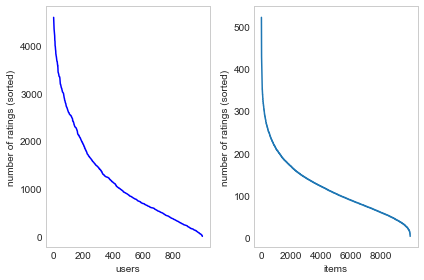

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

#### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1, verbose=False):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][:, valid_users]
    
    # LIL is a convenient format for constructing sparse matrices
    train = sp.lil_matrix(valid_ratings.shape)
    test = sp.lil_matrix(valid_ratings.shape)
    
    valid_ratings_i, valid_ratings_u, valid_ratings_v = sp.find(valid_ratings)
    valid_ratings_p_idx = np.random.permutation(range(len(valid_ratings_i)))
    
    n_test = int(p_test*len(valid_ratings_i))
    
    for idx in valid_ratings_p_idx[:n_test]:
        test[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]
        
    for idx in valid_ratings_p_idx[n_test:]:
        train[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]

    if verbose:
        print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
        print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
        print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    
    # convert to CSR for faster operations
    return valid_ratings, train.tocsr(), test.tocsr()

In [5]:
valid_ratings, train, test = split_data(ratings, num_items_per_user,
    num_users_per_item, min_num_ratings=10, p_test=0.1, verbose=True)

Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


### Read submission creation data

In [6]:
ratings_csr = ratings.tocsr()
sample_submission = load_data('{dp}sample_submission.csv'.format(dp=DATA_PATH))
sample_submission_csr = sample_submission.tocsr()

number of items: 10000, number of users: 1000


# 0.2 Auxiliary functions

In [7]:
def compute_division(a, b):
    """Computes element by element division.
    If x/0 returns 0.
    """
    # Raises error if vectors have different lengths
    assert(len(a) == len(b))
    
    # Computes division
    res = a.copy()
    for i in range(len(a)):
        if b[i] == 0:
            res[i] = 0
        else:
            res[i] = a[i] / b[i]

    return res

# 1 Baselines

In [8]:
# Baseline rating
def baseline_rating(data):
    """Implements baseline method for a ratings matrix
    using the global mean.
    """
    # Compute global mean using training data
    r_mean = data.sum() / data.count_nonzero()
    return r_mean


# User or item specific effect
def baseline_user_item_specific(data, mean, set_num=0):
    """Implements baseline method for a ratings matrix
    using either the user or the item mean,
    as indicated in parameter mean.
    """
    if mean=="user":
        flag = 1
        inv_flag = 0
    else:
        flag = 0
        inv_flag = 1

    num = max(set_num, data.shape[flag])
    
    # Obtain r_demeaned (ratings minus global avg)
    global_mean = baseline_rating(data)
    r_demeaned = data.copy()
    r_demeaned.data = (1.0 * r_demeaned.data) - global_mean
    
    # Compute means using training data
    # get rows, columns and values for elements in r_demeaned
    data_rcv = sp.find(r_demeaned)
    # compute means
    counts = np.bincount(data_rcv[flag], minlength=num)
    sums = np.bincount(data_rcv[flag], weights=data_rcv[2], minlength=num)
    means = compute_division(sums, counts)

    return means

# 2 Matrix Factorization

## Matrix Factorization with scikit's TruncatedSVD and baselines

In [10]:
from sklearn.decomposition import TruncatedSVD

In [11]:
def demean_matrix(data, verbose=False):
    """Removes the global, user and item means from a matrix.
    Returns the matrix and the computed means.
    """
    num_rows, num_cols = data.shape
    (rows, cols, vals) = sp.find(data)
    
    # Compute global, user and item means    
    global_mean = baseline_rating(data)
    item_means = baseline_user_item_specific(data, 'item')
    user_means = baseline_user_item_specific(data, 'user')
    
    # Substract the baseline of each element in 'data'
    train_vals = vals.copy()
    train_vals = 1.0 * train_vals
    
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(rows, cols)])
    train_vals = train_vals - baselines
    
    # Get matrix
    r_demeaned = sp.csr_matrix((train_vals, (rows, cols)),
        shape=(num_rows, num_cols))
    
    if verbose:
        print('---------------------------------------------')
        print('          Completed demean_matrix!           ')
        print('---------------------------------------------')
    
    return r_demeaned, global_mean, user_means, item_means

Next: Modify this function to use http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [ ]:
def matrix_factorization_SVD(data, test_data, test_flag, sub_flag=False,
    k=20, int_vals=False, sub_filename="new_submission", verbose=False):
    """Matrix factorization by SVD.

    If 'test_flag' is True, then 'data' should be the training dataset and
    'test_data' the test dataset. In this case sub_flag is ignored.
    
    If 'test_flag' is False and 'sub_flag' is True, then 'data' should be
    the entire ratings dataset and 'test_data' should be a sample submission.
    
    Both 'data' and 'test_data' should be csr sparse matrices.
    """

    assert test_flag or sub_flag, "Specify a task"
    assert k <= min(data.shape), "k must be smaller than the min dimension of 'data'"
    
    # Substract baseline from data
    r_demeaned, global_mean, user_means, item_means = demean_matrix(data, verbose=verbose)
    # Use scipy's svds
    U, sigma, Vt = svds(r_demeaned, k)
    sigma = np.diag(sigma)
    U_sigma = np.dot(U, sigma)
    
    if verbose:
        print('Finished fitting model')

    # Get non-zero elements
    (rows, cols, vals) = sp.find(data)
    (test_rows, test_cols, test_vals) = sp.find(test_data)

    if test_flag:        
        # Do predictions        
        baselines = np.array([(global_mean + item_means[i] + user_means[u])
            for (i, u) in zip(test_rows, test_cols)])
        interactions = np.array([(U_sigma[i,:].dot(Vt[:,u]))
            for (i, u) in zip(test_rows, test_cols)])
        pred_test = baselines + interactions
        if int_vals:
            pred_test = np.rint(pred_test)
      
        if verbose:
            print('Finished predicting')

        # Compute and print test error
        test_mse = calculate_mse(test_vals, pred_test)
        test_rmse = np.sqrt(test_mse / len(test_vals))
        
        if verbose:
            print("Test RMSE using baseline and matrix factorization: {e}".format(e=test_rmse)) 
            print()
            print('-----------------------------------------------')
            print(' Completed test in matrix_factorization_SVD! ')    
            print('-----------------------------------------------')
            
        return test_rmse, pred_test

    elif sub_flag:
        # Directly write predictions to submission file
        with open('{dp}{fn}.csv'.format(dp=PREDICTION_PATH, fn=sub_filename), 'w') as csvfile:
            fieldnames = ['Id', 'Prediction']
            writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
            writer.writeheader()
            for (i, u) in zip(test_rows, test_cols):
                interaction = U_sigma[i,:].dot(Vt[:,u])
                baseline = global_mean + user_means[u] + item_means[i]
                pred_i_u = interaction + baseline
                writer.writerow({'Id':'r{r}_c{c}'.format(r=i+1,c=u+1),'Prediction':pred_i_u})

        if verbose:
            print('-----------------------------------------------------')
            print(' Completed submission in matrix_factorization_SVD! ')    
            print('-----------------------------------------------------')

Test:

In [ ]:
test_rmse, pred_test = matrix_factorization_SVD(train, test, True,
    k=16, verbose=True)
# Test RMSE of matrix_factorization_SVD with k=16: 0.9938483199616733

test_rmse, pred_test = matrix_factorization_SVD(train,
    test, True, k=18, verbose=True)
# Test RMSE of matrix_factorization_SVD with k=18: 0.9941246387415831

test_rmse, pred_test = matrix_factorization_SVD(train,
    test, True, k=20, verbose=True)
# Test RMSE of matrix_factorization_SVD with k=20: 0.9943127900237189

test_rmse, pred_test = matrix_factorization_SVD(train,
    test, True, k=40, verbose=True)
# Test RMSE of matrix_factorization_SVD with k=40: 0.9967949498593854

test_rmse, pred_test = matrix_factorization_SVD(train,
    test, True, k=60, verbose=True)
# Test RMSE of matrix_factorization_SVD with k=60: 0.9988456305848287

test_rmse, pred_test = matrix_factorization_SVD(train, test,
    True, k=80, verbose=True)
# Test RMSE of matrix_factorization_SVD with k=80: 1.0016261672370745

test_rmse, pred_test = matrix_factorization_SVD(train, test,
    True, k=100, verbose=True)
# Test RMSE of matrix_factorization_SVD with k=100: 1.0032905394645015

Now we prepare the submission file for Kaggle: